In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline for compatibility with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values

In [44]:
df_2017 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/traindata_2017_v1.csv')
df_2018 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/testdata_2018_v1.csv')

## Graph Metric feature engineering

### Create graph structure
- weights are basically row count of source ip to dest ip, normalised

In [45]:
# Create graph structure for 2017 
G_2017 = nx.DiGraph()
network_df_2017 = df_2017[['Source IP', 'Destination IP', 'Flow ID']]

for _, row in network_df_2017.iterrows():
    src, dst = row["Source IP"], row["Destination IP"]
    if G_2017.has_edge(src, dst):
        G_2017[src][dst]['weight'] += 1
    else:
        G_2017.add_edge(src, dst, weight=1)
        
# Create graph structure for 2018
G_2018 = nx.DiGraph()
network_df_2018 = df_2018[['Source IP', 'Destination IP', 'Flow ID']]

for _, row in network_df_2018.iterrows():
    src, dst = row["Source IP"], row["Destination IP"]
    if G_2018.has_edge(src, dst):
        G_2018[src][dst]['weight'] += 1
    else:
        G_2018.add_edge(src, dst, weight=1)

In [46]:
# Calculate weighted degree and PageRank
weighted_degrees_2017 = dict(G_2017.degree(weight='weight'))
pagerank_scores_2017 = nx.pagerank(G_2017, weight='weight')
degree_centrality_2017 = nx.degree_centrality(G_2017)
core_number_2017 = nx.core_number(G_2017)

weighted_degrees_2018 = dict(G_2018.degree(weight='weight'))
pagerank_scores_2018 = nx.pagerank(G_2018, weight='weight')
degree_centrality_2018 = nx.degree_centrality(G_2018)
core_number_2018 = nx.core_number(G_2018)

In [47]:
# 1. Scaling function for metric dictionaries
def scale_metric_dict(metric_dict):
    df = pd.DataFrame(metric_dict.items(), columns=['IP', 'value'])
    scaler = MinMaxScaler()
    df['scaled'] = scaler.fit_transform(df[['value']])
    return dict(zip(df['IP'], df['scaled']))

# 2. Scale all 4 metrics per year
# For 2017
scaled_weighted_degrees_2017 = scale_metric_dict(weighted_degrees_2017)
scaled_pagerank_2017 = scale_metric_dict(pagerank_scores_2017)
scaled_centrality_2017 = scale_metric_dict(degree_centrality_2017)
scaled_core_2017 = scale_metric_dict(core_number_2017)

# For 2018
scaled_weighted_degrees_2018 = scale_metric_dict(weighted_degrees_2018)
scaled_pagerank_2018 = scale_metric_dict(pagerank_scores_2018)
scaled_centrality_2018 = scale_metric_dict(degree_centrality_2018)
scaled_core_2018 = scale_metric_dict(core_number_2018)

# 3. Feature mapping function (unchanged)
def get_avg_graph_metrics(row, degree_dict, pagerank_dict, centrality_dict, core_dict):
    src = row['Source IP']
    dst = row['Destination IP']
    
    deg_src = degree_dict.get(src, 0)
    deg_dst = degree_dict.get(dst, 0)
    pr_src = pagerank_dict.get(src, 0)
    pr_dst = pagerank_dict.get(dst, 0)
    cent_src = centrality_dict.get(src, 0)
    cent_dst = centrality_dict.get(dst, 0)
    core_src = core_dict.get(src, 0)
    core_dst = core_dict.get(dst, 0)
    
    return pd.Series({
        'average_weighted_degree': (deg_src + deg_dst) / 2,
        'average_page_rank': (pr_src + pr_dst) / 2,
        'average_degree_centrality': (cent_src + cent_dst) / 2,
        'average_k_core': (core_src + core_dst) / 2
    })

# 4. Add scaled features to df_2017
df_2017[[
    'average_weighted_degree', 'average_page_rank',
    'average_degree_centrality', 'average_k_core'
]] = df_2017.apply(
    get_avg_graph_metrics,
    axis=1,
    degree_dict=scaled_weighted_degrees_2017,
    pagerank_dict=scaled_pagerank_2017,
    centrality_dict=scaled_centrality_2017,
    core_dict=scaled_core_2017
)

# 5. Add scaled features to df_2018
df_2018[[
    'average_weighted_degree', 'average_page_rank',
    'average_degree_centrality', 'average_k_core'
]] = df_2018.apply(
    get_avg_graph_metrics,
    axis=1,
    degree_dict=scaled_weighted_degrees_2018,
    pagerank_dict=scaled_pagerank_2018,
    centrality_dict=scaled_centrality_2018,
    core_dict=scaled_core_2018
)

# ✅ Final check
print(df_2017.info())
print(df_2018.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480383 entries, 0 to 480382
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      480383 non-null  object 
 1   Source IP                    480383 non-null  object 
 2   Source Port                  480383 non-null  int64  
 3   Destination IP               480383 non-null  object 
 4   Destination Port             480383 non-null  int64  
 5   Protocol                     480383 non-null  int64  
 6   Timestamp                    480383 non-null  object 
 7   Flow Duration                480383 non-null  int64  
 8   Total Fwd Packets            480383 non-null  int64  
 9   Total Backward Packets       480383 non-null  int64  
 10  Total Length of Fwd Packets  480383 non-null  int64  
 11  Fwd Packet Length Max        480383 non-null  int64  
 12  Fwd Packet Length Min        480383 non-null  int64  
 13 

In [ ]:
# # NO scaling
# def get_avg_graph_metrics(row, degree_dict, pagerank_dict, centrality_dict, core_dict):
#     src = row['Source IP']
#     dst = row['Destination IP']
    
#     deg_src = degree_dict.get(src, 0)
#     deg_dst = degree_dict.get(dst, 0)
#     pr_src = pagerank_dict.get(src, 0)
#     pr_dst = pagerank_dict.get(dst, 0)
#     cent_src = centrality_dict.get(src, 0)
#     cent_dst = centrality_dict.get(dst, 0)
#     core_src = core_dict.get(src, 0)
#     core_dst = core_dict.get(dst, 0)
    
#     return pd.Series({
#         'average_weighted_degree': (deg_src + deg_dst) / 2,
#         'average_page_rank': (pr_src + pr_dst) / 2,
#         'average_degree_centrality': (cent_src + cent_dst) / 2,
#         'average_k_core': (core_src + core_dst) / 2
#     })

# # 3. Add raw features to df_2017
# df_2017[[
#     'average_weighted_degree', 'average_page_rank',
#     'average_degree_centrality', 'average_k_core'
# ]] = df_2017.apply(
#     get_avg_graph_metrics,
#     axis=1,
#     degree_dict=weighted_degrees_2017,
#     pagerank_dict=pagerank_scores_2017,
#     centrality_dict=degree_centrality_2017,
#     core_dict=core_number_2017
# )

# # 4. Add raw features to df_2018
# df_2018[[
#     'average_weighted_degree', 'average_page_rank',
#     'average_degree_centrality', 'average_k_core'
# ]] = df_2018.apply(
#     get_avg_graph_metrics,
#     axis=1,
#     degree_dict=weighted_degrees_2018,
#     pagerank_dict=pagerank_scores_2018,
#     centrality_dict=degree_centrality_2018,
#     core_dict=core_number_2018
# )

# # Final check
# print(df_2017.info())
# print(df_2018.info())


# Models

In [48]:
df_2017_final = df_2017.copy()
df_2018_final = df_2018.copy()
# df_2017_final.info()
# df_2018_final.info()

In [49]:
to_remove = ['Flow ID', 'Source IP', 'Destination IP', 'Destination Port','Timestamp', 'Protocol', 'Source Port'] 
df_2017_final.drop(columns=to_remove , inplace=True, errors='ignore')
df_2018_final.drop(columns=to_remove , inplace=True, errors='ignore')

In [50]:
# Separate features and target variables
X_train = df_2017_final.drop(columns=['Label'])
y_train = df_2017_final['Label']
X_test = df_2018_final.drop(columns=['Label'])
y_test = df_2018_final['Label']
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480383 entries, 0 to 480382
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow Duration                480383 non-null  int64  
 1   Total Fwd Packets            480383 non-null  int64  
 2   Total Backward Packets       480383 non-null  int64  
 3   Total Length of Fwd Packets  480383 non-null  int64  
 4   Fwd Packet Length Max        480383 non-null  int64  
 5   Fwd Packet Length Min        480383 non-null  int64  
 6   Fwd Packet Length Mean       480383 non-null  float64
 7   Bwd Packet Length Max        480383 non-null  int64  
 8   Bwd Packet Length Min        480383 non-null  int64  
 9   Flow Bytes/s                 480383 non-null  float64
 10  Flow Packets/s               480383 non-null  float64
 11  Flow IAT Mean                480383 non-null  float64
 12  Flow IAT Min                 480383 non-null  float64
 13 

### Logistic Regression 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/emmalim/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'lr__C': 0.01, 'smote__k_neighbors': 3}

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90   1343290
           1       1.00      0.48      0.65    575394

    accuracy                           0.85   1918684
   macro avg       0.91      0.74      0.78   1918684
weighted avg       0.87      0.85      0.83   1918684

Confusion Matrix:
 [[1342811     479]
 [ 296330  279064]]
Accuracy: 0.8453
Precision: 0.9983
Recall: 0.4850
F1 Score: 0.6528
ROC AUC Score: 0.9188

Top Feature Importances:
    Feature                       Coefficient
43      average_weighted_degree  2.756753   
6        Fwd Packet Length Mean -2.525379   
30                Down/Up Ratio -2.391732   
33             act_data_pkt_fwd -2.248884   
4         Fwd Packet Length Max -1.406233   
5         Fwd Packet Length Min  0.934759   
41                   Protocol_6  0.916586   
42                  Protocol_17 -0.913866   
7         B

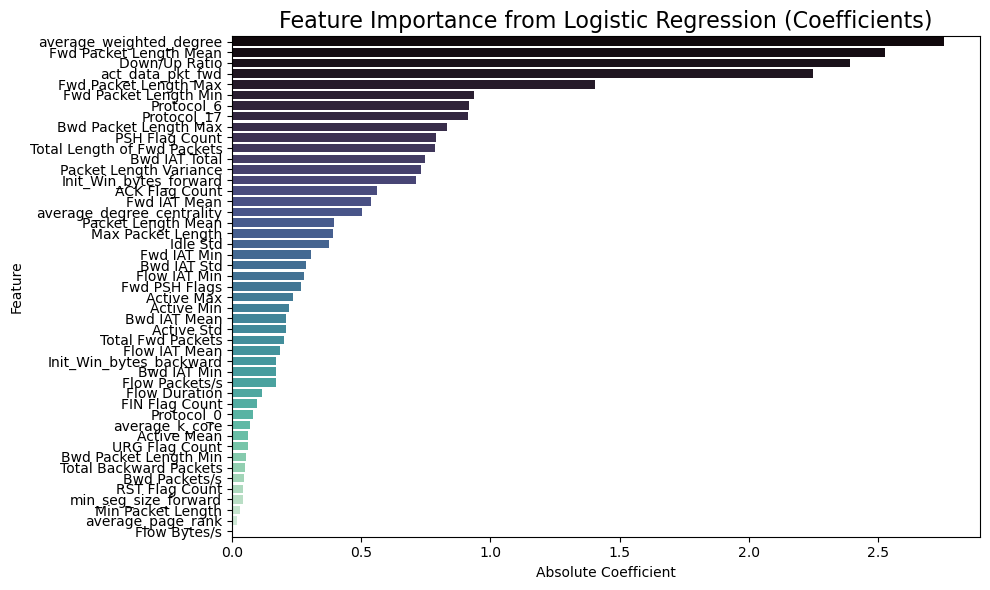

In [51]:
from imblearn.pipeline import Pipeline

#  Define Pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])


# Define Hyperparameter Grid
param_grid = {
    'lr__C': [0.01, 0.1, 1],  # Regularization strength
    'smote__k_neighbors': [3, 5, 7]  # SMOTE neighbor choices
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',    # Or 'roc_auc', 'precision'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


# Best Model & Predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}\n")


# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


# Get feature names from the training data
feature_names = X_train.columns

# Extract coefficients from the best logistic regression model
coefficients = best_model.named_steps['lr'].coef_[0]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Display the sorted importance
print("\nTop Feature Importances:\n", importance_df[['Feature', 'Coefficient']])

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df, palette='mako')
plt.title('Feature Importance from Logistic Regression (Coefficients)', fontsize=16)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### AdaBoost

Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ Best Params: {'adaboost__estimator': DecisionTreeClassifier(class_weight={0: 1, 1: 3}, max_depth=1), 'adaboost__learning_rate': 1.0, 'adaboost__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82   1343290
           1       0.58      0.50      0.54    575394

    accuracy                           0.74   1918684
   macro avg       0.69      0.67      0.68   1918684
weighted avg       0.73      0.74      0.74   1918684

Confusion Matrix:
 [[1138337  204953]
 [ 289289  286105]]
Accuracy: 0.7424
Precision: 0.5826
Recall: 0.4972
F1 Score: 0.5366
ROC AUC Score: 0.7796


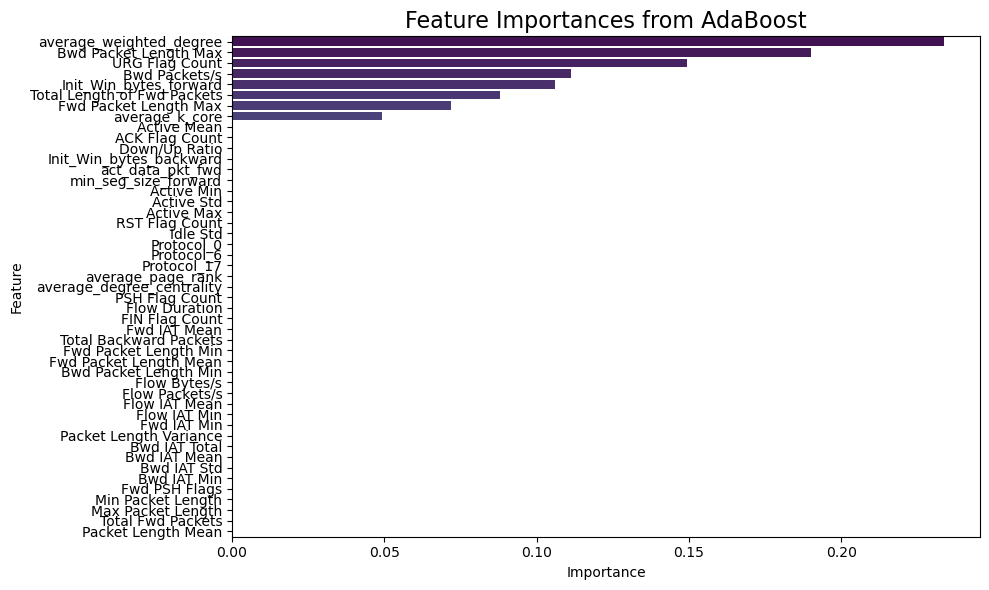

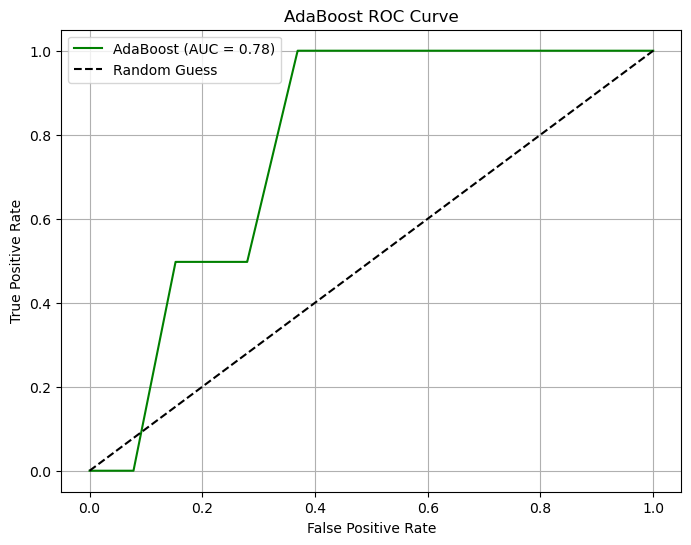

In [ ]:
from sklearn.pipeline import Pipeline


# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'adaboost__n_estimators': [100],
    'adaboost__learning_rate': [1.0],
    'adaboost__estimator': [
        DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3})
    ]
}

# GridSearchCV with F1 score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on 2017 training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"\n Best Params: {grid_search.best_params_}")


# Predict on 2018 test data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


feature_names = X_train.columns
importances = best_model.named_steps['adaboost'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from AdaBoost", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("AdaBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### Ensemble Log Reg and ADAboost

In [53]:
from sklearn.ensemble import VotingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Best individual pipelines
# Logistic Regression pipeline
logreg_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('lr', LogisticRegression(C=0.01, max_iter=1000, random_state=42))
])

# AdaBoost pipeline (no SMOTE here, as it may be tree-based and more robust to imbalance)
adaboost_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3}),
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    ))
])

# Ensemble using VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('adaboost', adaboost_pipeline)
    ],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

# Fit on training data
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90   1343290
           1       1.00      0.49      0.65    575394

    accuracy                           0.85   1918684
   macro avg       0.91      0.74      0.78   1918684
weighted avg       0.87      0.85      0.83   1918684

Confusion Matrix:
 [[1342821     469]
 [ 295865  279529]]
Accuracy: 0.8456
Precision: 0.9983
Recall: 0.4858
F1 Score: 0.6536
ROC AUC Score: 0.8391


### PCA plot on graph metrics

In [ ]:
selected_cols = [
    'average_weighted_degree', 
    'average_degree_centrality',
    'Label'
]

df_2017_analysis = df_2017[selected_cols]
X = df_2017_analysis[selected_cols]
y = df_2017_analysis['Label']  # 0 = benign, 1 = attack

from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

sample_size = 5000
if len(X) > sample_size:
    indices = np.random.choice(len(X), size=sample_size, replace=False)
    X_sample = X.iloc[indices]
    y_sample = y.iloc[indices]
else:
    X_sample = X
    y_sample = y

# Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_sample)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample,
    palette={0: 'blue', 1: 'red'}, alpha=0.6, s=20, edgecolor=None
)

custom_lines = [
    Line2D([0], [0], marker='o', color='w', label='Benign',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Attack',
           markerfacecolor='blue', markersize=8)
]

plt.legend(handles=custom_lines, title="Label")
plt.title('PCA of Graph Metrics')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()
